In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import h5py

from preprocess_data.preprocess_tueh import info_eeg_signal
from utils import bandpass_filter
from data.Dataset import MaskedDataset, MaskedDataset1
from models import SSL_EEG
from modules.decoders import MaskedDecoder
from modules.loss import MaskedMSELoss
from data.Dataset import MaskedDataset, MaskedDataset1, MaskedDataset2  
from data.DataModules import SSLDataModule

In [19]:
model = SSL_EEG.load_from_checkpoint('checkpoints/SSL-1s-v9.ckpt', decoder = MaskedDecoder, loss_fn = MaskedMSELoss)
model.eval()
conv = model.covnet
encoder = model.encoder
import torch.nn as nn
layer  = nn.Sequential(conv, encoder)
encoder.to('cuda')

TSTransformerEncoder(
  (project_inp): Linear(in_features=8, out_features=64, bias=True)
  (pos_enc): FixedPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=8, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
)

In [3]:
def get_attention_mask(input, model):

    output, attention_masks = model(input)
    
    att_mask = []
    for mask in attention_masks:
        attention_mask = mask.squeeze(0).cpu().detach().numpy()
        att_mask.append(attention_mask)
    return att_mask


In [4]:
def plot_attention(attention_masks, time_series):
    # Loop over each attention mask
    for i, attention_mask in enumerate(attention_masks):
        fig = plt.figure(figsize=(10, 10))
        spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, width_ratios=[1, 7, 0.5], height_ratios=[1, 7]) 

        # # Create the top plot (time series)
        # ax0 = fig.add_subplot(spec[0, 1])
        # ax0.plot(time_series)
        # ax0.set(ylabel='Value')
        # ax0.set_ylim([min(time_series), max(time_series)])  
        # ax0.set_xlim([0, len(time_series)])  

        # # Create the left plot (time series)
        # ax1 = fig.add_subplot(spec[1, 0])
        # ax1.plot(time_series, np.arange(len(time_series)))
        # ax1.set_ylim([0, len(time_series)])
        # ax1.invert_xaxis() 
        # ax1.invert_yaxis()  # Invert the y-axis to start from the top
        # ax1.set(xlabel='Value')
        
        # # Create the main plot (attention matrix)
        ax2 = fig.add_subplot(spec[1, 1])
        ax2.imshow(attention_mask, aspect='auto', cmap='binary')  # Use `attention_mask` instead of `attention_masks`
        ax2.set_xticks([])  
        ax2.set_yticks([])

        # # Hide the redundant axes
        # plt.setp(ax0.get_xticklabels(), visible=False)
        # plt.setp(ax1.get_yticklabels(), visible=False)

        # Add a colorbar in a separate space
        cbar_ax = fig.add_subplot(spec[1, 2])
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='binary'), cax=cbar_ax)
        cbar.set_label('Attention')

        # Reduce margins
        plt.subplots_adjust(wspace=0, hspace=0)

        # Display the plot
        plt.show()


In [5]:
eeg = os.path.join(os.getcwd(), 'data/TUEH-mask.h5')
masked_dataset = MaskedDataset2(hdf5_file=eeg, normalize= 'normalization')
# Create the data module with batch_size from wandb.config
datamodule = SSLDataModule(dataset = masked_dataset,
    batch_size=32,
    )

In [20]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider

@interact(i=IntSlider(min=0, max=7, step=1, value=0), j=IntSlider(min=0, max=99, step=1, value=0), continuous_update=False)
def plote(j):
    sample_uva = masked_dataset[j]
    sample_uva_masked = sample_uva[0].unsqueeze(0)
    sample_uva_raw = sample_uva[1].unsqueeze(0)
    sample_uva_mask = sample_uva[2].unsqueeze(0)
    attention_masks = get_attention_mask(sample_uva_masked.to('cuda'), layer)
    plot_attention(attention_masks, sample_uva_raw.squeeze().cpu().detach().numpy())

interactive(children=(IntSlider(value=0, description='j', max=99), Output()), _dom_classes=('widget-interact',…

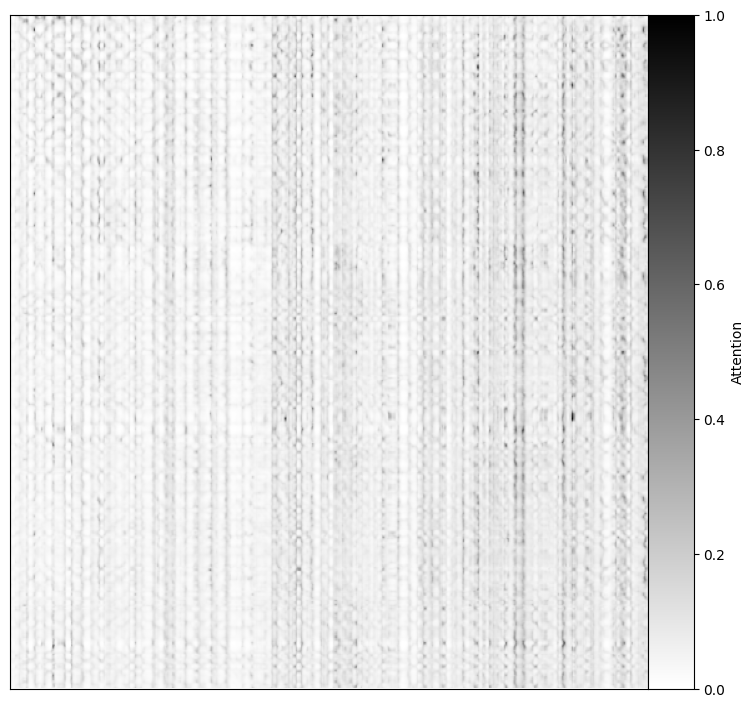

In [15]:
attention = get_attention_mask(sample_uva_raw.cuda(), layer)
plot_attention(attention, sample_uva_raw.squeeze(0).cpu().detach().numpy())

In [30]:
first_file = os.path.join('data/TUEH/', '002/002/aaaaaaky/s002_2012/01_tcp_ar', 'aaaaaaky_s002_t000.edf')
channels = [ 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG T5-REF', 'EEG T6-REF','EEG O1-REF']

signals = info_eeg_signal(first_file, channels)
print(signals.shape)

IndexError: tuple index out of range

In [6]:
# Go to the data folder
data_folder =  os.path.join(os.getcwd(), 'preprocess_data')
file_preprocessed = os.path.join(data_folder, 'signals_002_128_1s.csv')

# Open the file
preprocess_signals = np.loadtxt(file_preprocessed, delimiter=',')



In [32]:
import matplotlib.pyplot as plt

def plot_data(signals, preprocess_signals):
    # Plot all channels in the same figure
    fig, ax = plt.subplots(figsize=(20, 6))  # Adjust figsize as needed
    signals = signals[:, 128*3:256+128*3]  # Assuming signals shape is channels x samples
    signals = bandpass_filter(signals, 0.5, 50, 128)
    for i in range(signals.shape[0]):  # Assuming signals has shape (8, N)
        ax.plot(signals[0], label=f'Channel {i+1} Original')  # Plot the original signal of each channel
        ax.plot(preprocess_signals[0, :128], label=f'Channel {i+1} Processed')  # Plot the preprocessed signal
    ax.legend()  # Show legend to differentiate between channels
    plt.tight_layout()
    plt.show()


In [33]:

#axs, fig = plt.subplots(8,1, figsize=(20, 3)) # Adjust figsize as needed
def plot_data1(signals,preprocess_signals):
    # Plot the first segment of the eight channels
    fig, axs = plt.subplots(8,1, figsize=(20, 3)) # Adjust figsize as needed
    signals = signals[:, 256*3:256+128*3]  # Assuming signals shape is channels x samples
    signals = bandpass_filter(signals, 0.5, 50, 128)
    for i in range(8):
        axs[i].plot(signals[i]) # Plot the signal of each channel
        axs[i].plot(preprocess_signals[i, :128])
    #     axs[i].set_title('Channel {}'.format(i+1)) # Set title for each subplot
    # Optional: Improve layout to prevent title and axis labels from overlapping
    plt.tight_layout()
    plt.show()

In [36]:
preprocess_signals = preprocess_signals.reshape(-1, 8, 128)
plot_data(signals, preprocess_signals[0])    

NameError: name 'signals' is not defined

In [7]:
raw_data = os.path.join(data_folder, 'signals_002_128_1s.csv')
dataset = MaskedDataset(raw_data, raw_data,raw_data)

sample = dataset[40][1]

sample = sample.reshape(8, 128)
plt.plot(sample[0])
plt.tight_layout()
plt.show()

RuntimeError: shape '[8, 128]' is invalid for input of size 10240

In [ ]:
french_data = os.path.join(os.getcwd(), 'preprocess_data','SEED_DATASET.hdf5')

In [ ]:
french_dataset = MaskedDataset1(french_data,normalize= 'normalization')

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider

@interact(i=IntSlider(min=0, max=7, step=1, value=0), j=IntSlider(min=0, max=99, step=1, value=0), continuous_update=False)
def plote(j):
    sample_uva = french_dataset[j]
    sample_uva_masked = sample_uva[0]
    sample_uva_raw = sample_uva[1]
    sample_uva_mask = sample_uva[2]

    # Define x, assuming 128 data points for each sample
    x = np.linspace(0, 1270, 1280)

    # Create subplots for each channel
    fig, axs = plt.subplots(8, 1, figsize=(20, 15), sharex=True)
    
    for channel in range(8):
        axs[channel].plot(x, sample_uva_raw[:, channel], label='Raw Data')
        axs[channel].plot(x, sample_uva_masked[:, channel], label='Masked Data')
        #axs[channel].plot(x, sample_uva_mask[:, channel], label='Mask')
        
        axs[channel].legend(loc='upper right')
        axs[channel].grid(True)
        axs[channel].set_ylabel(f'Channel {channel+1}')

    # Set common labels
    plt.xlabel('Time Step')
    fig.suptitle(f'EEG Data Visualization for Sample {j}', fontsize=16)
    plt.show()



interactive(children=(IntSlider(value=0, description='j', max=99), Output()), _dom_classes=('widget-interact',…

In [ ]:
import os
import numpy as np
import h5py

seed_dataset = os.path.join(os.getcwd(), 'data', 'seed.h5')
print("Dataset exists:", os.path.exists(seed_dataset))

# Load the seed dataset
with h5py.File(seed_dataset, 'r') as hf:
    print('Keys:', list(hf.keys()))

    # Initialize lists to hold all signals and labels
    all_signals = []
    all_labels = []

    # Assuming the keys for signals and labels are consistently named and ordered
    # as 'signal_0', 'label_0', 'signal_1', 'label_1', ..., etc.
    signal_keys = [key for key in hf.keys() if key.startswith('signal')]
    label_keys = [key for key in hf.keys() if key.startswith('label')]

    # Check if the number of signal and label keys match
    if len(signal_keys) != len(label_keys):
        print("Warning: The number of signal and label keys do not match.")
    
    # Load each signal and label, assuming they are stored in matched pairs
    for signal_key, label_key in zip(signal_keys, label_keys):
        # Load the data and label, then append to lists
        signal = np.array(hf[signal_key])
        label = np.array(hf[label_key])
        
        all_signals.append(signal)
        all_labels.append(label)

    # Convert lists to numpy arrays
    all_signals_array = np.array(all_signals)
    all_labels_array = np.array(all_labels)

    print(f"All signals shape: {all_signals_array.shape}")
    print

# data = hf['Trial_1_Patient_10_Segment_0_Session_1']
# print('Keys:', list(data.keys()))

Dataset exists: True
Keys: ['label_0', 'label_1', 'label_10', 'label_100', 'label_1000', 'label_10000', 'label_10001', 'label_10002', 'label_10003', 'label_10004', 'label_10005', 'label_10006', 'label_10007', 'label_10008', 'label_10009', 'label_1001', 'label_10010', 'label_10011', 'label_10012', 'label_10013', 'label_10014', 'label_10015', 'label_10016', 'label_10017', 'label_10018', 'label_10019', 'label_1002', 'label_10020', 'label_10021', 'label_10022', 'label_10023', 'label_10024', 'label_10025', 'label_10026', 'label_10027', 'label_10028', 'label_10029', 'label_1003', 'label_10030', 'label_10031', 'label_10032', 'label_10033', 'label_10034', 'label_10035', 'label_10036', 'label_10037', 'label_10038', 'label_10039', 'label_1004', 'label_10040', 'label_10041', 'label_10042', 'label_10043', 'label_10044', 'label_10045', 'label_10046', 'label_10047', 'label_10048', 'label_10049', 'label_1005', 'label_10050', 'label_10051', 'label_10052', 'label_10053', 'label_10054', 'label_10055', '

In [ ]:
print(all_signals_array.shape)
print(all_labels_array.shape)

(88736, 8, 1280)
(88736, 1)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider

@interact(i=IntSlider(min=0, max=7, step=1, value=0), j=IntSlider(min=0, max=88000, step=1, value=0), continuous_update=False)
def plote(j):
    sample_uva = all_signals_array[j]

    # Define x, assuming 128 data points for each sample
    x = np.linspace(0, 1270, 1280)

    # Create subplots for each channel
    fig, axs = plt.subplots(8, 1, figsize=(20, 15), sharex=True)
    
    for channel in range(8):
        axs[channel].plot(x, sample_uva[channel, :], label='Raw Data')

        axs[channel].legend(loc='upper right')
        axs[channel].grid(True)
        axs[channel].set_ylabel(f'Channel {channel+1}')

    # Set common labels
    plt.xlabel('Time Step')
    fig.suptitle(f'EEG Data Visualization for Sample {j}', fontsize=16)
    plt.show()

interactive(children=(IntSlider(value=0, description='j', max=88000), Output()), _dom_classes=('widget-interac…